In [13]:
import cv2
import json
from src.lib.utils.pnp.cuboid_pnp_shell import pnp_shell
import matplotlib.pyplot as plt
import numpy as np
from src.lib.opts import opts
from itertools import permutations
import copy
import math
from pprint import pprint
import pickle
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from src.tools.objectron_eval.objectron.dataset.box import Box as Boxcls
from src.tools.objectron_eval.objectron.dataset.iou import IoU

In [14]:
# OPT:
opt = opts()
opt.nms = True
opt.obj_scale = True
opt.c = "cereal_box" # category
    
# Meta: 
# Load data from the PKL file
with open('cameraMatrix.pkl', 'rb') as f:
    camera = pickle.load(f)

print("Camera: \n", camera)

Camera: 
 [[3.96770805e+03 0.00000000e+00 2.48874091e+03]
 [0.00000000e+00 3.94294572e+03 2.11216245e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [15]:
# Take GT as imput:
with open('data/synthetic_data/real_test/anno.json', 'r') as f:
    data = json.load(f)

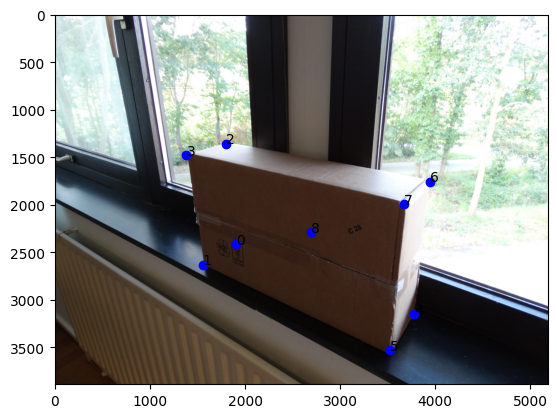

In [18]:
# first test with GT cereal:
img_id = 1
img_gt = data[img_id]
size = img_gt["whd"]
points =  img_gt["projection"]
w_points = img_gt["world"]


image = plt.imread("data/synthetic_data/real_test/" + str(img_id) + ".jpg")
plt.imshow(image)

for i, p in enumerate(points):
     plt.plot(p[0],p[1], 'bo')
     plt.text(p[0], p[1], f"{i}")

plt.show()

In [19]:
bbox = {'kps': points[:8], "obj_scale": size}
print("width", image.shape[1],"height", image.shape[0])
meta = {"width": image.shape[1],"height": image.shape[0], "camera_matrix": camera}
print("size: ", size)

width 5184 height 3888
size:  [1.7413793103448276, 1, 0.41379310344827586]


In [20]:
projected_points, point_3d_cam, scale, points_ori, bbox = pnp_shell(opt, meta, bbox, points[:8], size, OPENCV_RETURN=False)
gt_3dcam = bbox["kps_3d_cam"]
print(len(gt_3dcam))

9


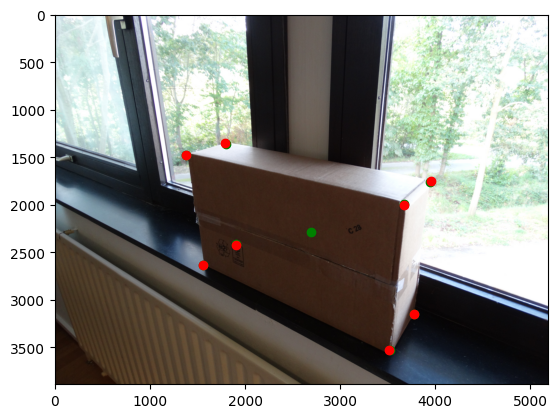

In [21]:
plt.imshow(image)

# GT
for p in points:
     plt.plot(int(p[0]),int(p[1]), 'go')

# After PnP  
for p in bbox["projected_cuboid"]:
     plt.plot(int(p[0]),int(p[1]), 'ro')

plt.show()

In [23]:
# Take GT as imput:
with open('exp/real_test_20epochs/' + str(img_id) + '.json', 'r') as f:
    data = json.load(f)

In [28]:
# Provided data with invalid points
kps_displacement_mean = data["objects"][0]["kps_displacement_mean"]
points = [(kps_displacement_mean[i], kps_displacement_mean[i + 1]) for i in range(0, len(kps_displacement_mean), 2)]
size = data["objects"][0]["obj_scale"]
print("Estimated: ", size)
# size = [1.7413793103448276, 1, 0.41379310344827586]

# Example 3D world
bbox = {'kps': points, "obj_scale": size}
meta = {"width": image.shape[1],"height": image.shape[0], "camera_matrix": camera}

projected_points, point_3d_cam, scale, points_ori, bbox = pnp_shell(opt, meta, bbox, points, size, OPENCV_RETURN=False)

Estimated:  [2.013028621673584, 1.0051311254501343, 1.316268801689148]


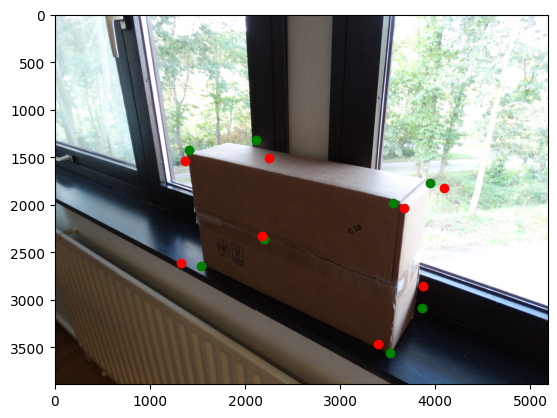

In [31]:
plt.imshow(image)

for p in points:
     plt.plot(int(p[0]),int(p[1]), 'go')

# After PnP  
for p in bbox["projected_cuboid"]:
     plt.plot(int(p[0]),int(p[1]), 'ro')
plt.show()

In [32]:
gt_box = Boxcls(gt_3dcam) # doet pnp op gt pixel coördinaten -> om de 3D wereld coordinaten te krijgen
detect_box = Boxcls(point_3d_cam) 

iou = IoU(detect_box, gt_box) # calculate IoU:
result = iou.iou()
print(result)
print(gt_box.vertices)
print(translated_box.vertices)

0.05403498758821508


In [34]:
trans = gt_box.vertices[0] - detect_box.vertices[0]
translated = []

for i in range(len(detect_box.vertices)):
    translated.append(detect_box.vertices[i]+trans)
    
translated = np.array(translated)
translated_box = Boxcls(translated)

In [36]:
iou = IoU(translated_box, gt_box) # calculate IoU:
result = iou.iou()
print(result)
print(gt_box.vertices)
print(translated_box.vertices)

0.27030496877578947
[[ 0.11617724  0.02434562 -2.77814276]
 [ 0.28785899 -0.52800147 -3.62451426]
 [ 0.43712716 -0.77762275 -3.33017948]
 [-0.6146254  -0.56131302 -3.19508175]
 [-0.46535722 -0.8109343  -2.90074697]
 [ 0.69771169  0.85962554 -2.65553854]
 [ 0.84697987  0.61000426 -2.36120376]
 [-0.20477269  0.82631398 -2.22610603]
 [-0.05550451  0.57669271 -1.93177125]]
[[ 0.11617724  0.02434562 -2.77814276]
 [ 0.27470923 -0.52129337 -3.94374548]
 [ 0.47637265 -1.21902882 -2.85405902]
 [-0.68815464 -0.41320142 -3.69634036]
 [-0.48649122 -1.11093686 -2.60665389]
 [ 0.71884569  1.1596281  -2.94963162]
 [ 0.92050911  0.46189266 -1.85994515]
 [-0.24401818  1.26772006 -2.70222649]
 [-0.04235476  0.56998461 -1.61254003]]


In [37]:
z_trans = gt_box.vertices[0][2] - detect_box.vertices[0][2]
translated = []
for i in range(len(detect_box.vertices)):
        translated_vertex = detect_box.vertices[i].copy()  # Assuming vertices are lists or arrays
        translated_vertex[2] += z_trans  # Apply translation to the z component
        translated.append(translated_vertex)
translated = np.array(translated)
translated_box = Boxcls(translated)

In [38]:
iou = IoU(translated_box, gt_box) # calculate IoU:
result = iou.iou()
print(result)
print(gt_box.vertices)
print(translated_box.vertices)

0.2678755825164641
[[ 0.11617724  0.02434562 -2.77814276]
 [ 0.28785899 -0.52800147 -3.62451426]
 [ 0.43712716 -0.77762275 -3.33017948]
 [-0.6146254  -0.56131302 -3.19508175]
 [-0.46535722 -0.8109343  -2.90074697]
 [ 0.69771169  0.85962554 -2.65553854]
 [ 0.84697987  0.61000426 -2.36120376]
 [-0.20477269  0.82631398 -2.22610603]
 [-0.05550451  0.57669271 -1.93177125]]
[[ 0.10743632  0.17500541 -2.77814276]
 [ 0.26596832 -0.37063358 -3.94374548]
 [ 0.46763174 -1.06836902 -2.85405902]
 [-0.69689555 -0.26254162 -3.69634036]
 [-0.49523213 -0.96027707 -2.60665389]
 [ 0.71010477  1.3102879  -2.94963162]
 [ 0.9117682   0.61255245 -1.85994515]
 [-0.2527591   1.41837985 -2.70222649]
 [-0.05109567  0.72064441 -1.61254003]]


In [44]:
def translate_along_optical_axis(gt_box, detect_box):
    optical_center = np.array([0, 0, 0])  # Optical center at world origin (0,0,0)
    
    # Extract center points from both boxes (assuming first element is the center)
    center_gt = gt_box.vertices[0]  # Ground truth box center (first vertex)
    center_detect = detect_box.vertices[0]  # Detection box center (first vertex)
    print(center_detect)
    print(center_gt)

    # Get the optical axis (vector from optical center to the detection box center)
    optical_line = center_detect - optical_center
    print('line: ', optical_line)
    optical_line = optical_line / np.linalg.norm(optical_line)  # Normalize the vector
    print('norm vector: ', optical_line)

    # Compute the translation required to move the detection center to the ground truth center
    translation_vector = center_gt - center_detect
    shift_magnitude = np.dot(translation_vector, optical_line)  # Project shift on the optical axis

    # Apply this translation to the detection center and all its vertices
    translated = []
    for vertex in detect_box.vertices:
        translated_vertex = vertex + optical_line * shift_magnitude  # Translate along optical axis
        translated.append(translated_vertex)

    # Convert the list of translated vertices to a numpy array (if required by your Boxcls)
    translated = np.array(translated)
    translated_box = Boxcls(translated)

    return translated_box

In [46]:
translated_box = translate_along_optical_axis(gt_box, detect_box)
iou = IoU(translated_box, gt_box) # calculate IoU:
result = iou.iou()
print(result)

print(gt_box.vertices)
print(translated_box.vertices)

[ 0.10743632  0.17500541 -3.58529836]
[ 0.11617724  0.02434562 -2.77814276]
line:  [ 0.10743632  0.17500541 -3.58529836]
norm vector:  [ 0.02991676  0.04873208 -0.99836375]
0.26315601398257843
[[ 0.11617724  0.02434562 -2.77814276]
 [ 0.28785899 -0.52800147 -3.62451426]
 [ 0.43712716 -0.77762275 -3.33017948]
 [-0.6146254  -0.56131302 -3.19508175]
 [-0.46535722 -0.8109343  -2.90074697]
 [ 0.69771169  0.85962554 -2.65553854]
 [ 0.84697987  0.61000426 -2.36120376]
 [-0.20477269  0.82631398 -2.22610603]
 [-0.05550451  0.57669271 -1.93177125]]
[[ 0.08311652  0.13539036 -2.77371314]
 [ 0.24164852 -0.41024864 -3.93931586]
 [ 0.44331194 -1.10798408 -2.8496294 ]
 [-0.72121535 -0.30215668 -3.69191074]
 [-0.51955193 -0.99989213 -2.60222428]
 [ 0.68578498  1.27067284 -2.945202  ]
 [ 0.8874484   0.57293739 -1.85551553]
 [-0.2770789   1.37876479 -2.69779687]
 [-0.07541547  0.68102935 -1.60811041]]
